In [1]:
%matplotlib inline

from IPython.display import Image

# Realistic simulation of X-ray radiographs using gVirtualXRay
## With a realistic beam spectrum and taking into account the energy response of the detector
### Authors: F. P. Vidal and J. M. Létang

**Purpose:** In this notebook, we aim to demonstrate how to use gVirtualXRay to generate analytic simulations on GPU. We take into account i) a realistic anatomical phantom, ii) a realistic clinical scenario, iii) a realistic beam spectrum,  and iv) the energy response of the detector.

**Material and Methods:** We downloaded the paediatric phantom from the [p**E**diat**R**ic dosimet**R**y personalized platf**OR**m (ERROR) project](https://error.upatras.gr/). It corresponds to the anatomy of a 5 year old boy. We generated surfaces meshes from the segmented data using [VTK](https://www.vtk.org/). We used the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

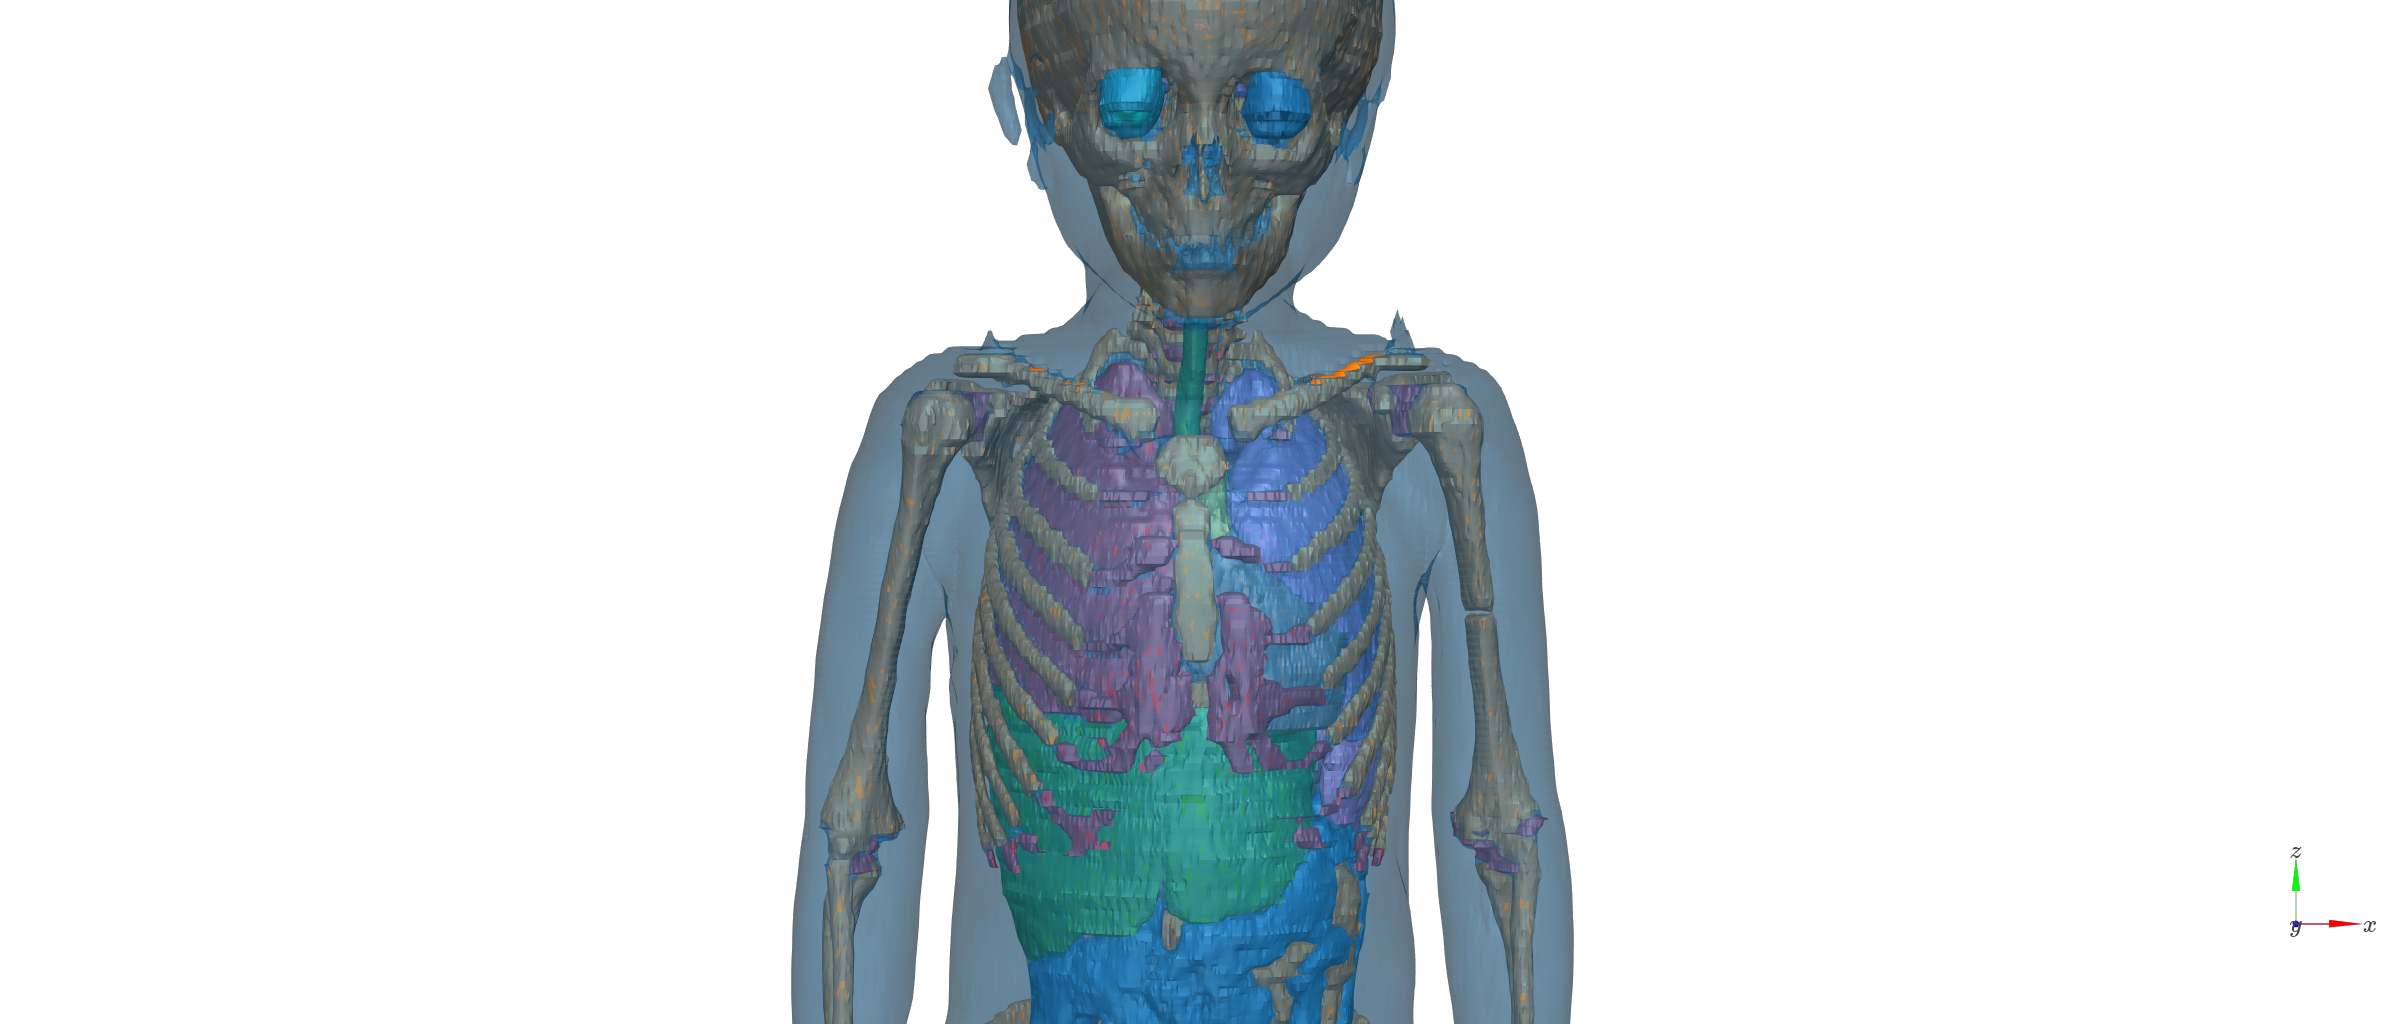

In [2]:
Image(filename="pediatric_model.png", width=400)

In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic. The voltage is 85 kV. The filteration is 0.1 mm of copper and 1 mm of aluminium. The energy response of the detector is considered. It mimics a 600-micron thick CsI scintillator.

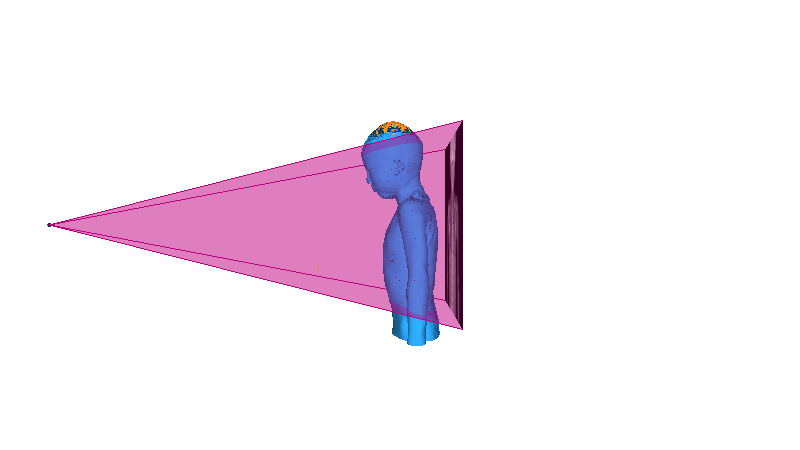

In [3]:
# Image(filename="pediatric-setup.png")
Image(filename="screenshot-negative.png")

**Results:** The X-ray image can be retrieved from the GPU and saved on the disk, or displayed using Matplotlib or others, using various look-up tables.

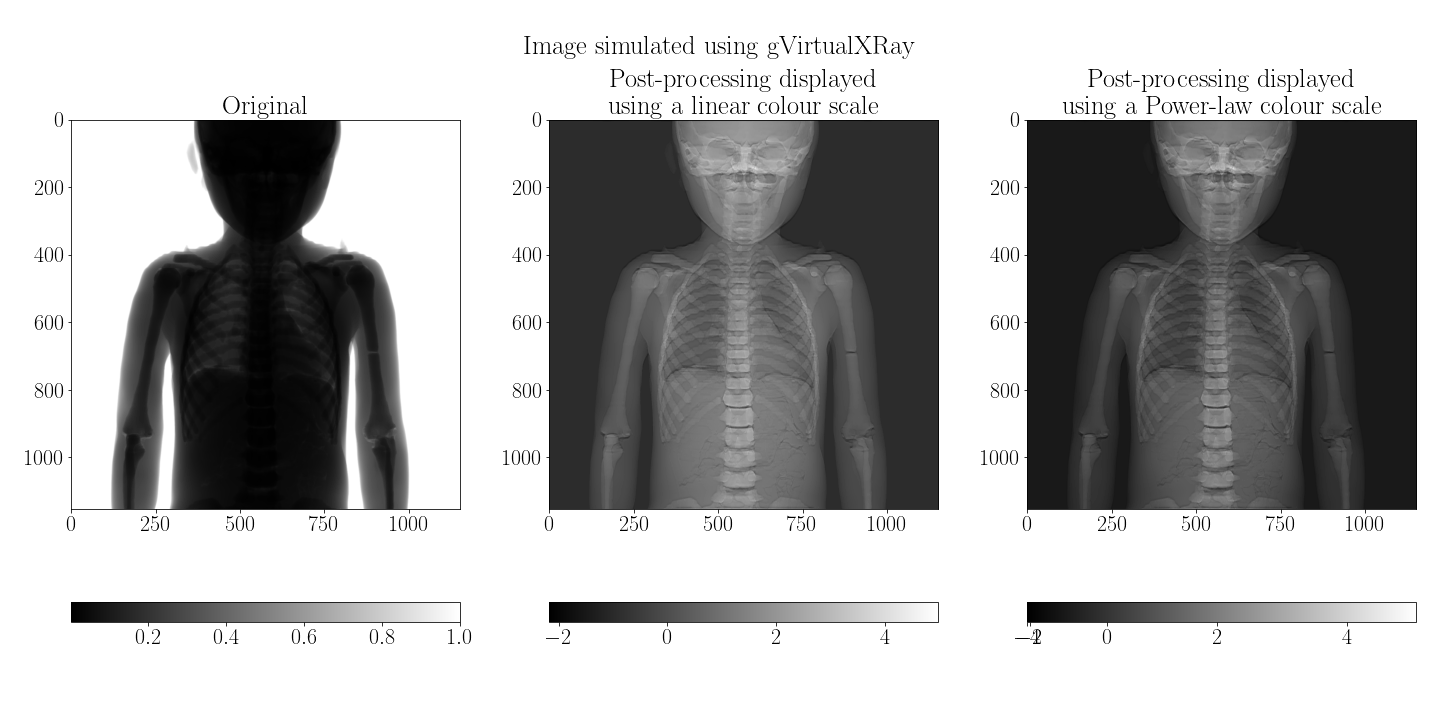

In [4]:
Image(filename="xray_image.png")

## Import packages

In [5]:
import os # Locate files

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import urllib, zipfile

from time import sleep

import matplotlib

import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)


from tifffile import imsave # Write TIFF files

import k3d, base64
import SimpleITK as sitk
from stl import mesh

from sitk2vtk import sitk2vtk
import vtk

import PIL
from skimage.filters import gaussian # Implementing the image sharpening filter


import gvxrPython3 as gvxr # Simulate X-ray images
import json2gvxr # Set gVirtualXRay and the simulation up

SimpleGVXR 1.0.1 (2022-03-10T15:28:42) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2022-03-10T15:28:36) [Compiler: GNU g++] on Linux


## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [6]:
json2gvxr.initGVXR("configuration.json", "EGL")

Create an OpenGL context: 800x450
Wed Mar 16 15:11:50 2022 ---- Create window gvxrStatus:	Create window 


0
1.5
4.5.0 NVIDIA 455.45.01



Wed Mar 16 15:11:50 2022 ---- EGL version: Wed Mar 16 15:11:50 2022 ---- OpenGL version supported by this platform OpenGL renderer:   GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    4.5.0 NVIDIA 455.45.01
OpenGL vender:     NVIDIA Corporation
Wed Mar 16 15:11:50 2022 ---- Use OpenGL 4.5.0 0 500 500
0 0 800 450


## X-ray source

We create an X-ray source. It is a point source.

In [7]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, -1000.0, 0.0, 'mm']
	Source shape: PointSource


## Spectrum

The spectrum is polychromatic.

In [8]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


params["Source"]["Beam"] {'kvp': 85, 'tube angle': 12, 'filter': [['Al', 1], ['Cu', 0.1]]}
['Al', 1]
['Cu', 0.1]


Plot the spectrum

## Detector

Create a digital detector

In [9]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, 150.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [1152, 1152]
	Energy response: responseDetector.txt in MeV
	Pixel spacing: [0.4340277777777778, 0.4340277777777778, 'mm']


## Sample

Download and unzip the phantom

In [10]:
if not os.path.exists("pediatric_phantom_data"):
    os.mkdir("pediatric_phantom_data")

if not os.path.exists("pediatric_phantom_data/Pediatric phantom.zip"):
    urllib.request.urlretrieve("https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1", "pediatric_phantom_data/Pediatric phantom.zip")

    with zipfile.ZipFile("pediatric_phantom_data/Pediatric phantom.zip","r") as zip_ref:
        zip_ref.extractall("pediatric_phantom_data")

Load the phantom

In [11]:
phantom = sitk.ReadImage("pediatric_phantom_data/Pediatric phantom/Pediatric_model.mhd")

Wed Mar 16 15:11:51 2022 ---- Initialise the renderer


Load the labels

In [12]:
df = pd.read_csv("labels.dat")

Process every structure of the phantom

In [13]:
# A function to extract an isosurface from a binary image
def extractSurface(vtk_image, isovalue):

    iso = vtk.vtkContourFilter()
    if vtk.vtkVersion.GetVTKMajorVersion() >= 6:
        iso.SetInputData(vtk_image)
    else:
        iso.SetInput(vtk_image)

    iso.SetValue(0, isovalue)
    iso.Update()
    return iso.GetOutput()

# A function to write STL files
def writeSTL(mesh, name):
    """Write an STL mesh file."""
    try:
        writer = vtk.vtkSTLWriter()
        if vtk.vtkVersion.GetVTKMajorVersion() >= 6:
            writer.SetInputData(mesh)
        else:
            writer.SetInput(mesh)
        writer.SetFileTypeToBinary()
        writer.SetFileName(name)
        writer.Write()
        writer = None
    except BaseException:
        print("STL mesh writer failed")
        exc_type, exc_value, exc_traceback = sys.exc_info()
        traceback.print_exception(
            exc_type, exc_value, exc_traceback, limit=2, file=sys.stdout)
    return None


In [14]:
def resampleImage(itk_image, out_spacing=[1.0, 1.0, 1.0]):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))
    ]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    resample.SetInterpolator(sitk.sitkGaussian)

    return resample.Execute(itk_image) 

In [15]:
if not os.path.exists("pediatric_phantom_data/meshes"):
    os.mkdir("pediatric_phantom_data/meshes")

if not os.path.exists("pediatric_phantom_data/segmentations"):
    os.mkdir("pediatric_phantom_data/segmentations")

meshes = []

smoothed_filter = sitk.AntiAliasBinaryImageFilter()
smoothed_filter.SetMaximumRMSError(smoothed_filter.GetMaximumRMSError() * 0.1)
smoothed_filter.SetNumberOfIterations(int(smoothed_filter.GetNumberOfIterations() * 1.5))

for threshold, organ in zip(df["Label"], df["Organs"]):

    # Ignore air
    if organ != "Air":

        print("Process", organ)
        
        seg_fname = "pediatric_phantom_data/segmentations/" + organ + ".mha"
        mesh_fname = "pediatric_phantom_data/meshes/" + organ + ".stl"
        meshes.append(mesh_fname)

        # Only create the mesh if it does not exist
        if not os.path.exists(mesh_fname):

            # Threshold the phantom
            binary_image = (phantom == threshold)

            # Resample
            original_spacing = binary_image.GetSpacing()
            new_spacing = [original_spacing[0], original_spacing[0], original_spacing[0]]

            # resampled_image = resampleImage(binary_image, new_spacing)    
    
            # Smooth the binary segmentation
            # smoothed_binary_image = smoothed_filter.Execute(resampled_image)
            smoothed_binary_image = smoothed_filter.Execute(binary_image)

            # Create a VTK image
            vtkimg = sitk2vtk(smoothed_binary_image, centre=True)

            vtk_mesh = extractSurface(vtkimg, 0)
            writeSTL(vtk_mesh, mesh_fname)

Process Muscle
Process Bone
Process Stomach-Interior
Process Cartilage
Process Brain
Process Bladder
Process Gallbladder
Process Heart
Process Kidneys-right
Process Kidneys-left
Process Small-Intestine
Process Large-Intestine
Process Liver
Process Lung-right
Process Lung-left
Process Pancreas
Process Spleen
Process Stomach
Process Thymus
Process Eyes-right
Process Eyes-left
Process Skull
Process Trachea


Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [16]:
json2gvxr.initSamples("configuration.json", verbose=0)

pediatric_phantom_data/meshes/Muscle.stl	nb_faces:	1248515	nb_vertices:	3745545	bounding_box (in cm):	(-17.9396, -10.8644, -30.9017)	(16.6015, 11.1493, 28.6503)
pediatric_phantom_data/meshes/Bone.stl	nb_faces:	375065	nb_vertices:	1125195	bounding_box (in cm):	(-16.788, -23.6328, -30.9017)	(15.1855, 9.86328, 16.1961)
pediatric_phantom_data/meshes/Stomach-Interior.stl	nb_faces:	6832	nb_vertices:	20496	bounding_box (in cm):	(-1.31836, -2.34375, -16.9685)	(4.05273, 3.02734, -8.59684)
pediatric_phantom_data/meshes/Cartilage.stl	nb_faces:	109364	nb_vertices:	328092	bounding_box (in cm):	(-16.748, -4.29687, -30.9017)	(15.4785, 8.6914, 16.5136)
pediatric_phantom_data/meshes/Brain.stl	nb_faces:	108050	nb_vertices:	324150	bounding_box (in cm):	(-7.28337, -9.96093, 16.3501)	(7.4707, 5.76172, 28.1222)
pediatric_phantom_data/meshes/Bladder.stl	nb_faces:	3028	nb_vertices:	9084	bounding_box (in cm):	(-3.75976, 2.14844, -30.9017)	(0.146484, 5.46875, -29.7572)
pediatric_phantom_data/meshes/Gallbladder.

Visualise the phantom

In [17]:
up_x,up_y, up_z = json2gvxr.params["Detector"]["UpVector"]
src_x_pos, src_y_pos, src_z_pos, src_unit_pos = json2gvxr.params["Source"]["Position"]
det_x_pos, det_y_pos, det_z_pos, det_unit_pos = json2gvxr.params["Detector"]["Position"]
sdd = math.sqrt(math.pow(src_x_pos - det_x_pos, 2) + math.pow(src_y_pos - det_y_pos, 2) + math.pow(src_z_pos - det_z_pos, 2))

w, h, unit_size = json2gvxr.params["Detector"]["Size"]
half_w = w / 2
half_h = h / 2

half_view_angle_rad = math.atan(half_w / sdd)
half_view_angle_deg = half_view_angle_rad * 180 / math.pi
fov = 2.0 * half_view_angle_deg

camera = [
    src_x_pos, src_y_pos, src_z_pos, # position of the camera in xyz space
    det_x_pos, det_y_pos, det_z_pos, # the point where camera is currently looking at
    -up_x, -up_y, -up_z  # orientation (up direction), this vector cannot be [0,0,0])
]

plot = k3d.plot()
plot.background_color = 0xffffff

for sample in json2gvxr.params["Samples"]:
    
    label = sample["Label"]
    
    fname = sample["Path"]

    r, g, b, a = gvxr.getAmbientColour(label)
    R = math.floor(255*r)
    G = math.floor(255*g)
    B = math.floor(255*b)
    A = math.floor(255*a)

    k3d_color = 0;
    k3d_color |= (R & 255) << 16;
    k3d_color |= (G & 255) << 8;
    k3d_color |= (B & 255);

    mesh_from_stl_file = mesh.Mesh.from_file(fname)

    if label == "Muscle":
        opacity = 0.4
    else:
        opacity = 1
    geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                          range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                          color=k3d_color, 
                          wireframe=False, 
                          flat_shading=False,
                          name=fname,
                          opacity=opacity)

    plot += geometry   

plot.display()

Output()

In [18]:
plot.camera_auto_fit=False
plot.grid_visible=False
plot.camera = camera
plot.camera_fov = fov

In [19]:
def saveK3D(plot, fname):
    plot.fetch_screenshot()
    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

In [20]:
fname = 'pediatric_model.png'

if not os.path.exists(fname):
    saveK3D(plot, fname)

In [21]:
# Opens a image in RGB mode
img = PIL.Image.open(fname)

width, height = img.size
half_width = width / 2
half_height = height / 2

# Setting the points for cropped image
left = half_width - half_height
top = 0
right = half_width + half_height
bottom = height
 
# Cropped image of above dimension
# (It will not change original image)
img = img.crop((left, top, right, bottom))
 
img.save("pediatric_model-cropped.png")

In [22]:
# add detector
# Define the 4 vertices of the quad
p0 = [det_x_pos - half_w, det_y_pos, det_z_pos - half_h]
p1 = [det_x_pos + half_w, det_y_pos, det_z_pos - half_h]
p2 = [det_x_pos + half_w, det_y_pos, det_z_pos + half_h]
p3 = [det_x_pos - half_w, det_y_pos, det_z_pos + half_h]

vertices = np.array([p0, p1, p2, p3])

# Define the 12 triangles composing the cube
faces = np.array([\
    [0,1,2],
    [0,2,3]])

# Create the mesh
quad = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        quad.vectors[i][j] = vertices[f[j],:]

# Write the mesh to file "detector.stl"
fname = "detector.stl"
quad.save(fname)

# Y-Z flip
model_matrix = [
    w, 0.0, 0.0, det_x_pos,
    0.0, -h, 0.0, det_z_pos,
    0.0, 0.0, 1, -det_y_pos,
    0.0, 0.0, 0.0, 1.0
]

texture = k3d.texture(open('projection-sharpen.png', 'br').read(), 'png', 
                      rotation=[math.radians(90),1,0,0], 
                      model_matrix = model_matrix,
                      name='Detector')

plot += texture 

In [23]:
plot.camera = [-819.866815044995, -769.0583719216149, -54.27664865088702,
               0, 150, 0,
               0, 0, 1]

fname = 'visualisation.png'

if not os.path.exists(fname):
    saveK3D(plot, fname)

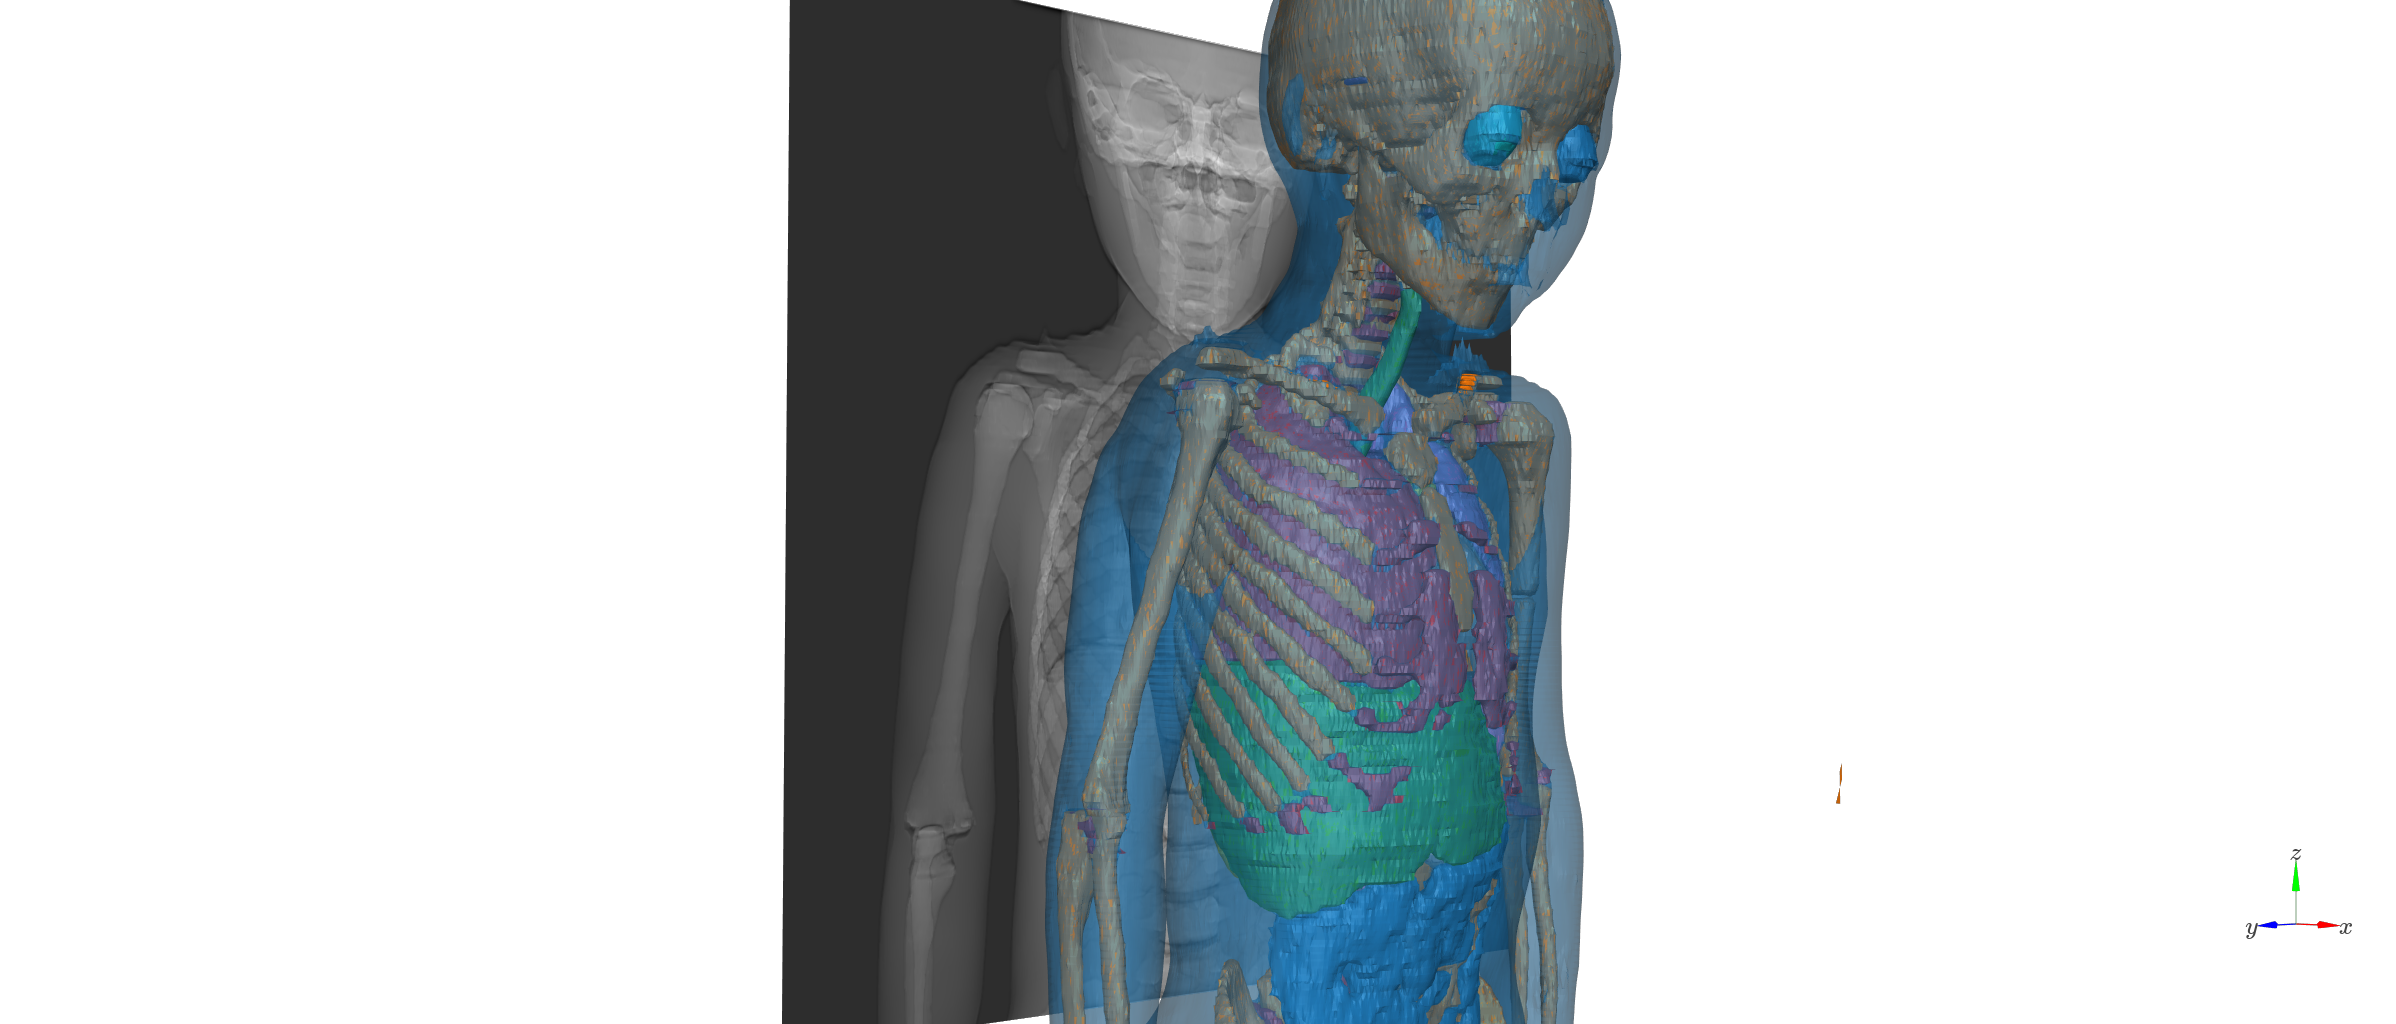

In [24]:
Image(filename=fname)

In [25]:
# Not working

# plot.get_snapshot()

# with open('output/snapshot.html','w') as fp:
#     fp.write(plot.snapshot)

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [26]:
gvxr.enableArtefactFilteringOnGPU()
xray_image = np.flip(gvxr.computeXRayImage(), 0)

Save an X-ray image

In [27]:
if not os.path.exists("output"):
    os.mkdir("output")

imsave('output/projection-raw.tif', xray_image.astype(np.single))

Flat-field correction

In [28]:
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [29]:
white = np.ones(xray_image.shape) * total_energy_in_MeV
dark = np.zeros(xray_image.shape)

xray_image_flat = np.flip((xray_image - dark) / (white - dark))

Save the corresponding image

In [30]:
imsave('output/projection-flat.tif', xray_image_flat.astype(np.single))

# Post-processing using image sharpening

In [31]:
def standardisation(img):
    return (img - img.mean()) / img.std()

In [32]:
def logImage(xray_image: np.array, min_val: float, max_val: float) -> np.array:
    
    log_epsilon = 1.0e-9

    shift_filter = -math.log(min_val + log_epsilon)
    
    if min_val != max_val:
        scale_filter = 1.0 / (math.log(max_val + log_epsilon) - math.log(min_val + log_epsilon))
    else:
        scale_filter = 1.0

    corrected_image = np.log(xray_image + log_epsilon)

    return (corrected_image + shift_filter) * scale_filter

In [33]:
def applyLogScaleAndNegative(image: np.array) -> np.array:
    temp = logImage(image, image.min(), image.max())
    return 1.0 - temp

In [34]:
def sharpen(image, ksize, alpha, shift, scale):
    details = image - gaussian(image, ksize)    

    return scale * (shift + image) + alpha * details

In [35]:
corrected_xray_image = applyLogScaleAndNegative(xray_image_flat)
corrected_xray_image = corrected_xray_image.astype(np.single)

standardised_corrected_xray_image = standardisation(corrected_xray_image)

In [36]:
sigma1, sigma2, alpha, shift, scale = [3.883818026543349, 1.0000036461307866, 8.223048387996197, 3.097919939169109, 1.9255625476572062]
sharpened_x_ray_image = standardisation(sharpen(standardised_corrected_xray_image, [sigma1, sigma2], alpha, shift, scale))

In [37]:
temp = sharpened_x_ray_image - sharpened_x_ray_image.min()
temp /= temp.max()
temp *= 255
imsave('output/projection-sharpen.tif', temp.astype(np.uint8))

## Display the X-ray image

In [38]:
gamma = 0.75

vmin = sharpened_x_ray_image.min()
vmax = sharpened_x_ray_image.max()

def interact_plot():

    fig_plot = plt.figure(figsize= (20,10))

    ax = plt.subplot(131)
    plt.imshow(xray_image_flat, cmap="gray")
    plt.colorbar(orientation='horizontal')
    ax.set_title("Original")

    plt.suptitle("Image simulated using gVirtualXRay", y=0.95)
    ax = plt.subplot(132)
    plt.imshow(sharpened_x_ray_image, cmap="gray")
    plt.colorbar(orientation='horizontal')
    ax.set_title("Post-processing displayed\nusing a linear colour scale")

    ax_img = plt.subplot(133)
    plt.imshow(sharpened_x_ray_image, norm=PowerNorm(gamma=1./gamma), cmap="gray")
    plt.colorbar(orientation='horizontal')
    ax_img.set_title("Post-processing displayed\nusing a Power-law colour scale")

    plt.tight_layout()
    plt.savefig('xray_image.png')
    plt.close()

    ## Callback function: plot y=Acos(x+phi)
    def update_plot(gamma):
        ax_img.imshow(sharpened_x_ray_image, norm=PowerNorm(gamma=1./gamma), cmap="gray")
        display(fig_plot)

    interact(update_plot,
             gamma=widgets.FloatSlider(value=gamma, min=0.01, max=10.0, step=0.05, description="gamma"))

interact_plot();

interactive(children=(FloatSlider(value=0.75, description='gamma', max=10.0, min=0.01, step=0.05), Output()), …

In [39]:
# save a image using extension
pil_img = PIL.Image.fromarray(temp)

if pil_img.mode != 'RGB':
    pil_img = pil_img.convert('L')
    
pil_img.save("projection-sharpen.png")

## Visualisation using gVirtualXRay

In [40]:
gvxr.displayScene()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(1549.6787109375)
gvxr.useNegative()

angle = math.pi / 2.0
rotation_matrix_x = np.array([ 1, 0, 0, 0,
                               0, math.cos(angle), -math.sin(angle), 0,
                               0, math.sin(angle),  math.cos(angle), 0,
                               0, 0, 0, 1])

rotation_matrix_z = np.array([ math.cos(angle), -math.sin(angle), 0, 0,
                               math.sin(angle),  math.cos(angle), 0, 0,
                               0, 0, 1, 0,
                               0, 0, 0, 1])

rotation_matrix_x.shape = [4,4]
rotation_matrix_z.shape = [4,4]

transformation_matrix = np.identity(4)

transformation_matrix = np.matmul(rotation_matrix_x, transformation_matrix)
transformation_matrix = np.matmul(rotation_matrix_z, transformation_matrix)

gvxr.setSceneRotationMatrix(transformation_matrix.flatten())

gvxr.setWindowBackGroundColour(1, 1, 1)

gvxr.displayScene()

In [41]:
screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

In [42]:
fname = 'screenshot-negative.png'
plt.imsave(fname, screenshot)

# VTK rendering

In [43]:
def stl2actor(fname, colour, opacity):

    # Load the file
    reader = vtk.vtkSTLReader()
    reader.SetFileName(fname)
    reader.Update()

    
    #  Remove any duplicate points.
    clean_filter = vtk.vtkCleanPolyData()
    
    if vtk.vtkVersion.GetVTKMajorVersion() >= 6:
        clean_filter.SetInputData( reader.GetOutput() )
    else:
        clean_filter.SetInput( reader.GetOutput() )
                
    clean_filter.Update()

    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(clean_filter.GetOutputPort())

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(colour)
    actor.GetProperty().SetOpacity(opacity)
    
    print(fname, colour, opacity)
    return actor

## All done

Destroy the window

In [44]:
gvxr.destroyAllWindows()


0(0x55605434a520)
